# Animate the coordinates

### from https://matplotlib.org/2.1.2/gallery/animation/simple_3danim.html

In [1]:
import mediapipe as mp
import os
import cv2
import numpy as np

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd

In [4]:
%matplotlib notebook

In [4]:
%matplotlib inline

## Load in coordinates

In [5]:
X = []
Y = []
title = []
coorDataLocation = "D:/Thesis/ELAR-Data/heavyImputedArrayData/"
dirData = os.listdir(coorDataLocation)
for i, data in enumerate(dirData):
    if i % 2:
        continue
    coorLoad = np.loadtxt(coorDataLocation + data)
    coorShape= np.loadtxt(coorDataLocation + dirData[i + 1])
    try:
        coorLoad = coorLoad.reshape(coorLoad.shape[0], coorLoad.shape[1] // int(coorShape[2]), int(coorShape[2]))
    except:
        print(data, dirData[i + 1], coorLoad.shape, coorShape.shape)
    title.append(data)
    X.append(coorLoad)
    if len(X) > 99999: # load in the first 99999
        break
len(X)

14096

In [3]:
# initialize Pose estimator
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [4]:
connections = set(mp_pose.POSE_CONNECTIONS)

In [6]:
connections_list = [connect for connect in connections if connect[0] <= 24 and connect[1] <= 24]
connections_list

[(15, 21),
 (16, 20),
 (18, 20),
 (3, 7),
 (14, 16),
 (11, 23),
 (6, 8),
 (15, 17),
 (16, 22),
 (4, 5),
 (5, 6),
 (12, 24),
 (23, 24),
 (0, 1),
 (9, 10),
 (1, 2),
 (0, 4),
 (11, 13),
 (15, 19),
 (16, 18),
 (12, 14),
 (17, 19),
 (2, 3),
 (11, 12),
 (13, 15)]

In [8]:
max(connections_list)

(23, 24)

In [7]:
np.savetxt('connections_list', np.array(connections_list))

## Create xy xz yz arrays

In [9]:
size = 128

# Extract xy xz yz from all videos

In [14]:
failedVids = []
successfullVideo = {}
for videoNum, video in enumerate(X):
    if len(video.shape) != 3:
        failedVids.append(videoNum)
        continue
    newVideo = []
    for frame in video:
        newVideo.append(frame[0:25])
    video = np.array(newVideo)

    padding = 0
    x_max = max(np.array(video).T[0].reshape(1,-1)[0]) + padding/2
    x_min = min(np.array(video).T[0].reshape(1,-1)[0]) - padding/2
    x_range = abs(x_max - x_min)
    y_max = max(np.array(video).T[1].reshape(1,-1)[0]) + padding/2
    y_min = min(np.array(video).T[1].reshape(1,-1)[0]) - padding/2
    y_range = abs(y_max - y_min)
    z_max = max(np.array(video).T[2].reshape(1,-1)[0]) + padding/2
    z_min = min(np.array(video).T[2].reshape(1,-1)[0]) - padding/2
    z_range = abs(z_max - z_min)

    plotFrame = False

    xy_frames = []
    xz_frames = []
    yz_frames = []

    for frame in video:
        frame  = frame.T
        x = frame[0]
        y = frame[1]
        z = frame[2]
        xy = np.zeros((size,size))
        xz = np.zeros((size,size))
        yz = np.zeros((size,size))

        coord2d = [(xy, (x_max, x_min, x_range, x), (y_max, y_min, y_range, y)), (xz,(x_max, x_min, x_range, x), (z_max, z_min, z_range, z)),(yz, (z_max,z_min, z_range, z), (y_max,y_min, y_range, y))]
        for axis2d, axis1, axis2 in coord2d:
            axis1_max, axis1_min, axis1_range, data1 = axis1
            axis2_max, axis2_min, axis2_range,data2 = axis2
            max_edge, big_axis = max((axis1_range, 'a1'), (axis2_range, 'a2'))
            if axis1_min < 0:
                axis1_offset = abs(axis1_min)
            else:
                axis1_offset = -1 * abs(axis1_min)
            if axis2_min < 0:
                axis2_offset = abs(axis2_min)
            else:
                axis2_offset = -1 * abs(axis2_min)
            if plotFrame:
                fig = plt.figure()

            multiplier = (size - 1)/max_edge
            for connection in connections_list:
                p1, p2 = connection
                point_coor1 = ((data1[p1] + axis1_offset) * multiplier, (data2[p1] + axis2_offset) * multiplier)
                point_coor2 = ((data1[p2] + axis1_offset) * multiplier, (data2[p2] + axis2_offset) * multiplier)
                
                m = (point_coor2[1]- point_coor1[1])/(point_coor2[0]- point_coor1[0])
                lineX = lambda x : m * x - m * point_coor1[0] + point_coor1[1]
                lineY = lambda y : ((y - point_coor1[1])/m) + point_coor1[0]

                # Plot
                if plotFrame:
                    plt.plot([point_coor1[0], point_coor2[0]],[point_coor1[1], point_coor2[1]])

                # Point Location
                a1p1Index = int(point_coor1[0])
                a2p1Index = int(point_coor1[1])
                a1p2Index = int(point_coor2[0])
                a2p2Index = int(point_coor2[1])
                
                # create line between y
                if a2p1Index < a2p2Index:
                    for y_index in range(a2p1Index,a2p2Index + 1):
                        if y_index >= point_coor1[1] and y_index <= point_coor2[1]:
                            x_index = int(lineY(y_index))
                            axis2d[y_index, x_index] = 1
                            if plotFrame:
                                plt.scatter(x_index, y_index, c="red")
                else:
                    for y_index in range(a2p2Index,a2p1Index + 1):
                        if y_index >= point_coor2[1] and y_index <= point_coor1[1]:
                            x_index = int(lineY(y_index))
                            axis2d[y_index, x_index] = 1
                            if plotFrame:
                                plt.scatter(x_index, y_index, c="red")

                if a1p1Index < a1p2Index:
                    for x_index in range(a1p1Index,a1p2Index + 1):
                        if x_index >= point_coor1[0] and x_index <= point_coor2[0]:
                            y_index = int(lineX(x_index))
                            axis2d[y_index, x_index] = 1
                            if plotFrame:
                                plt.scatter(x_index, y_index, c="blue")
                else:
                    for x_index in range(a1p2Index, a1p1Index + 1):
                        if x_index >= point_coor2[0] and x_index <= point_coor1[0]:
                            y_index = int(lineX(x_index))
                            axis2d[y_index, x_index] = 1
                            if plotFrame:
                                plt.scatter(x_index, y_index, c="blue")
        xy_frames.append(xy)
        xz_frames.append(xz)
        yz_frames.append(yz)
    xy_frames = np.array(xy_frames)
    xz_frames = np.array(xz_frames)
    yz_frames = np.array(yz_frames)
    if len(xy_frames) > 0:
        print("saving: ", title[videoNum][:-4])
        np.savetxt("D:/Thesis/ELAR-Data/heavyImputedArrayDataExtract/"+ title[videoNum][:-4] +"_xy.npy", xy_frames.reshape(xy_frames.shape[0], -1))
        np.savetxt("D:/Thesis/ELAR-Data/heavyImputedArrayDataExtract/"+ title[videoNum][:-4]  +"_xy_shape.npy", np.array(xy_frames.shape))
        np.savetxt("D:/Thesis/ELAR-Data/heavyImputedArrayDataExtract/"+ title[videoNum][:-4] +"_xz.npy", xz_frames.reshape(xz_frames.shape[0], -1))
        np.savetxt("D:/Thesis/ELAR-Data/heavyImputedArrayDataExtract/"+ title[videoNum][:-4]  +"_xz_shape.npy", np.array(xz_frames.shape))
        np.savetxt("D:/Thesis/ELAR-Data/heavyImputedArrayDataExtract/"+ title[videoNum][:-4] +"_yz.npy", yz_frames.reshape(yz_frames.shape[0], -1))
        np.savetxt("D:/Thesis/ELAR-Data/heavyImputedArrayDataExtract/"+ title[videoNum][:-4]  +"_yz_shape.npy", np.array(yz_frames.shape))
    # successfullVideo[videoNum] = {'xy':xy_frames, 'xz':xz_frames, 'yz':yz_frames}

saving:  ABOUT1_SBS1A3c7a_950_1280
saving:  ABOUT2(7)_BAPB1c2b_1090_2260
saving:  ABOUT2(FALSE-START)_MTDBA2c7a_780_980
saving:  ABOUT2_AAPB2c7a_310_800
saving:  ABOUT2_AJPB2c7a_1135_2270
saving:  ABOUT2_AMGA1c2a_1580_1820
saving:  ABOUT2_AMGA1c2a_730_1170
saving:  ABOUT2_AMW2A1c2b_890_1020
saving:  ABOUT2_BCHA2c7a_4470_5330
saving:  ABOUT2_BCHA2c7a_5750_6050
saving:  ABOUT2_BMKB2c7a_1010_1700
saving:  ABOUT2_MBHA1c2a_4750_5175
saving:  ABOUT2_MFKA1c2a_6180_6460
saving:  ABOUT2_MGCA1c2b_4880_5510
saving:  ABOUT2_MGCA1c2b_52725_53635
saving:  ABOUT2_MGCA1c2b_5840_6150
saving:  ABOUT2_MTDBA2c7a_1290_2190
saving:  ABOUT2_PGMB1c2a_1230_2110
saving:  ABOUT2_PJEB1c2a_2500_3100
saving:  ABOUT2_PNAA1c2b_1880_2660
saving:  ABOUT2_SBS1A1c2b_7320_7630
saving:  ABOUT2_SPKA1c2a_171110_171409
saving:  ABOUT2_STMB1c2a_13650_13800
saving:  ABOUT2_STMB1c2a_3370_3770
saving:  ACCEPT_SASA1c2b_40478_41228
saving:  ACCOMMODATION-2H_AAM2A2c6iv_1220_2000
saving:  ACCURATE_AAM1A2c6ii_67410_68030
saving:  ACCU

C:\Users\KAI\AppData\Local\Temp\ipykernel_28868\383697367.py:60: RuntimeWarning: divide by zero encountered in scalar divide
  m = (point_coor2[1]- point_coor1[1])/(point_coor2[0]- point_coor1[0])


saving:  ALL_PDRA1c2a_119460_119640
saving:  ALL_PDRA1c2a_124810_125120
saving:  ALL_PDRA1c2a_57660_58020
saving:  ALL_PDRA1c2a_84770_85190
saving:  ALL_PDSA1c2a_98080_98450
saving:  ALL_PGMB1c2a_110770_111270
saving:  ALL_PGMB1c2a_26545_27425
saving:  ALL_PGMB1c2a_51831_52681
saving:  ALL_PGMB1c2a_97955_98175
saving:  ALL_PHHA1c2a_137010_138060
saving:  ALL_PJEB1c2a_8770_9250
saving:  ALL_SLWA1c2a_55329_55499
saving:  ALL_SMGB1c2a_131084_132264
saving:  ALL_SMGB1c2a_137904_138384
saving:  ALL_SNCB2c2a_173810_174230
saving:  ALL_SPKA1c2a_104993_105397
saving:  ALL_SPKA1c2a_123845_124527
saving:  ALL_SPKA1c2a_146045_146526
saving:  ALL_SPKA1c2a_149060_149803
saving:  ALL_SPKA1c2a_76314_76654
saving:  ALL_SPKA1c2a_80893_81383
saving:  ALL_SPKA1c2a_81866_82202
saving:  ALL_SPKA1c2a_88534_89004
saving:  ALL_SPKA1c2a_92386_92644
saving:  ALL_SPKA1c2a_98746_99456
saving:  ALL_STMB1c2a_126670_126770
saving:  ALMOST-2H_AAM2A1c2b_101450_101780
saving:  ALMOST_AFLA1c2b_47940_48120
saving:  ALMOS

# Convert to images 
### This was implemented as it took 30 min to reload in data when testing

In [3]:
from PIL import Image
import os
import numpy as np
import time

In [5]:
coorDataLocation = "D:/Thesis/ELAR-Data/heavyImputedArrayDataExtract/"
dirData = os.listdir(coorDataLocation)
for i, data in enumerate(dirData):
    if i % 2:
        continue
    coorLoad = np.loadtxt(coorDataLocation + data)
    coorShape= np.loadtxt(coorDataLocation + dirData[i + 1])

    if i % 200 == 0:
        print('completed: ' +  str(i))

    try:
        coorLoad = coorLoad.reshape(coorLoad.shape[0], coorLoad.shape[1] // int(coorShape[2]), int(coorShape[2]))
    except:
        print("error")
        print(data, dirData[i + 1], coorLoad.shape, coorShape.shape)
    try:
        os.mkdir('D:/Thesis/ELAR-Data/test/' + data[:-4])
        for i, frame in enumerate(coorLoad):
            image_data = [[(255, 255, 255) if pixel == 0 else (0, 0, 0) for pixel in row] for row in frame]
            image = Image.new('RGB', (len(frame[0]), len(frame)))
            image.putdata([pixel for row in image_data for pixel in row])
            # Save the image to a file
            image.save('D:/Thesis/ELAR-Data/test/' + data[:-4] + '/' + str(i) +'.png')
    except:
        print(i)

completed: 0
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180
182
184
186
188
190
192
194
196
198
completed: 200
200
202
204
206
208
210
212
214
216
218
220
222
224
226
228
230
232
234
236
238
240
242
244
246
248
250
252
254
256
258
260
262
264
266
268
270
272
274
276
278
280
282
284
286
288
290
292
294
296
298
300
302
304
306
308
310
312
314
316
318
320
322
324
326
328
330
332
334
336
338
340
342
344
346
348
350
352
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
completed: 400
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
456
458
460
462
464
466
468
470
472
474
476
478
480
482
484
486
488
490
492
494
496
498
500
502
504


## Destroy page

# Other Section

# Code to convert singular frame

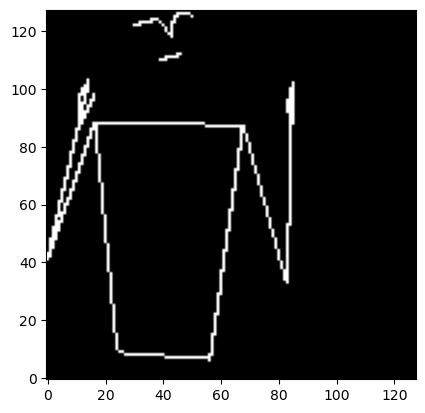

In [ ]:
video = X[5]
newVideo = []
for frame in video:
    newVideo.append(frame[0:25])
video = np.array(newVideo)

padding = 0
x_max = max(np.array(video).T[0].reshape(1,-1)[0]) + padding/2
x_min = min(np.array(video).T[0].reshape(1,-1)[0]) - padding/2
x_range = abs(x_max - x_min)
y_max = max(np.array(video).T[1].reshape(1,-1)[0]) + padding/2
y_min = min(np.array(video).T[1].reshape(1,-1)[0]) - padding/2
y_range = abs(y_max - y_min)
z_max = max(np.array(video).T[2].reshape(1,-1)[0]) + padding/2
z_min = min(np.array(video).T[2].reshape(1,-1)[0]) - padding/2
z_range = abs(z_max - z_min)

plotFrame = False

frame  = video[5].T
x = frame[0]
y = frame[1]
z = frame[2]
xy = np.zeros((size,size))
xz = np.zeros((size,size))
yz = np.zeros((size,size))

coord2d = [(xy, (x_max, x_min, x_range, x), (y_max, y_min, y_range, y)), (xz,(x_max, x_min, x_range, x), (z_max, z_min, z_range, z)),(yz, (y_max,y_min, y_range, y), (z_max,z_min, z_range, z))]
q = 0
for axis2d, axis1, axis2 in coord2d:
    axis1_max, axis1_min, axis1_range, data1 = axis1
    axis2_max, axis2_min, axis2_range,data2 = axis2
    max_edge, big_axis = max((axis1_range, 'a1'), (axis2_range, 'a2'))
    if axis1_min < 0:
        axis1_offset = abs(axis1_min)
    else:
        axis1_offset = -1 * abs(axis1_min)
    if axis2_min < 0:
        axis2_offset = abs(axis2_min)
    else:
        axis2_offset = -1 * abs(axis2_min)
    if plotFrame:
        fig = plt.figure()

    multiplier = (size - 1)/max_edge
    for connection in connections_list:
        p1, p2 = connection
        point_coor1 = ((data1[p1] + axis1_offset) * multiplier, (data2[p1] + axis2_offset) * multiplier)
        point_coor2 = ((data1[p2] + axis1_offset) * multiplier, (data2[p2] + axis2_offset) * multiplier)
        
        m = (point_coor2[1]- point_coor1[1])/(point_coor2[0]- point_coor1[0])
        lineX = lambda x : m * x - m * point_coor1[0] + point_coor1[1]
        lineY = lambda y : ((y - point_coor1[1])/m) + point_coor1[0]

        # Plot
        if plotFrame:
            plt.plot([point_coor1[0], point_coor2[0]],[point_coor1[1], point_coor2[1]])

        # Point Location
        a1p1Index = int(point_coor1[0])
        a2p1Index = int(point_coor1[1])
        a1p2Index = int(point_coor2[0])
        a2p2Index = int(point_coor2[1])
        
        # create line between y
        if a2p1Index < a2p2Index:
            for y_index in range(a2p1Index,a2p2Index + 1):
                if y_index >= point_coor1[1] and y_index <= point_coor2[1]:
                    x_index = int(lineY(y_index))
                    axis2d[y_index, x_index] = 1
                    if plotFrame:
                        plt.scatter(x_index, y_index, c="red")
        else:
            for y_index in range(a2p2Index,a2p1Index + 1):
                if y_index >= point_coor2[1] and y_index <= point_coor1[1]:
                    x_index = int(lineY(y_index))
                    axis2d[y_index, x_index] = 1
                    if plotFrame:
                        plt.scatter(x_index, y_index, c="red")

        if a1p1Index < a1p2Index:
            for x_index in range(a1p1Index,a1p2Index + 1):
                if x_index >= point_coor1[0] and x_index <= point_coor2[0]:
                    y_index = int(lineX(x_index))
                    axis2d[y_index, x_index] = 1
                    if plotFrame:
                        plt.scatter(x_index, y_index, c="blue")
        else:
            for x_index in range(a1p2Index, a1p1Index + 1):
                if x_index >= point_coor2[0] and x_index <= point_coor1[0]:
                    y_index = int(lineX(x_index))
                    axis2d[y_index, x_index] = 1
                    if plotFrame:
                        plt.scatter(x_index, y_index, c="blue")
    break
plt.imshow(axis2d, cmap='gray', origin='lower')
plt.show()